In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import seaborn as sns
import random
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm
import pandas as pd
import os
import os, csv, time, random
import torch
import torch.utils.data as Data
import numpy as np
from torch import nn, optim
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import SGD

In [ ]:
# Data Loader Parameters
BATCH_SIZE = 2
BUFFER_SIZE = 10
TRAIN_SPLIT = 280

# GRU Parameters
EVALUATION_INTERVAL = 50
EPOCHS = 10
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [ ]:
data = pd.read_csv('./sample_data/dataset/H1_nav.csv')

frame_150 = data.iloc[:549,:10]
print(frame_150)

     FrameNumber       x       y       z    HMDRX     HMDRY     HMDRZ  \
0              1  0.0500  1.7868 -1.0947   6.9163  350.8206  359.9912   
1              2  0.0498  1.7871 -1.0951   6.9116  351.1272    0.0094   
2              3  0.0498  1.7872 -1.0955   6.8915  351.3081    0.0221   
3              4  0.0498  1.7870 -1.0961   6.9375  351.5385  359.9731   
4              5  0.0497  1.7865 -1.0969   7.1456  351.7421  359.8803   
..           ...     ...     ...     ...      ...       ...       ...   
544           78 -0.2347  1.7775 -0.9928  13.4230    8.2536  355.9264   
545           79 -0.2347  1.7762 -0.9906  14.2977    8.4653  356.3082   
546           80 -0.2346  1.7758 -0.9896  14.5123    8.4457  356.5488   
547           81 -0.2343  1.7750 -0.9875  15.0098    8.2159  357.0574   
548           82 -0.2340  1.7745 -0.9864  15.4411    7.9168  357.1393   

    Participant Dataset  ViewFrame  
0        P01_V1      H1          1  
1        P01_V1      H1          2  
2        P01

In [ ]:
features_considered = ['x', 'y', 'z', 'HMDRX', 'HMDRY', 'HMDRZ']
#features_considered = ['x', 'y', 'z']
features = frame_150[features_considered]
features.index = frame_150['ViewFrame']
features.head()

,x,y,z,HMDRX,HMDRY,HMDRZ
ViewFrame,,,,,,
1,0.0500,1.7868,-1.0947,6.9163,350.8206,359.9912
2,0.0498,1.7871,-1.0951,6.9116,351.1272,0.0094
3,0.0498,1.7872,-1.0955,6.8915,351.3081,0.0221
4,0.0498,1.7870,-1.0961,6.9375,351.5385,359.9731
5,0.0497,1.7865,-1.0969,7.1456,351.7421,359.8803


In [ ]:
dataset = features.values
data_mean = dataset[:].mean(axis=0)
data_std = dataset[:].std(axis=0)
dataset = (dataset-data_mean)/data_std

display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

,x,y,z,HMDRX,HMDRY,HMDRZ
ViewFrame,,,,,,
1,0.719265,1.768347,-1.255305,-1.870203,1.254116,0.501280
2,0.717165,1.797655,-1.263128,-1.871060,1.255913,-2.113341
3,0.717165,1.807424,-1.270951,-1.874724,1.256973,-2.113249
4,0.717165,1.787885,-1.282686,-1.866338,1.258322,0.501149
5,0.716115,1.739038,-1.298332,-1.828400,1.259515,0.500475


In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns, ['b','r', 'g', 'c' , 'm', 'y'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"Predicted {var.title()}")
        if prediction.any():
          pass
            # plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
            #         label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
past_history = 100
future_target = 50
STEP = 1
TRAIN_SPLIT = 300
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset, dataset,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(200, 100, 6, 1, 1)
(200, 50, 6, 1, 1)
(99, 100, 6, 1, 1)
(99, 50, 6, 1, 1)
Single window of past history : (100, 6, 1, 1)
Target temperature to predict : (50, 6, 1, 1)


In [ ]:
BATCH_SIZE = 10

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

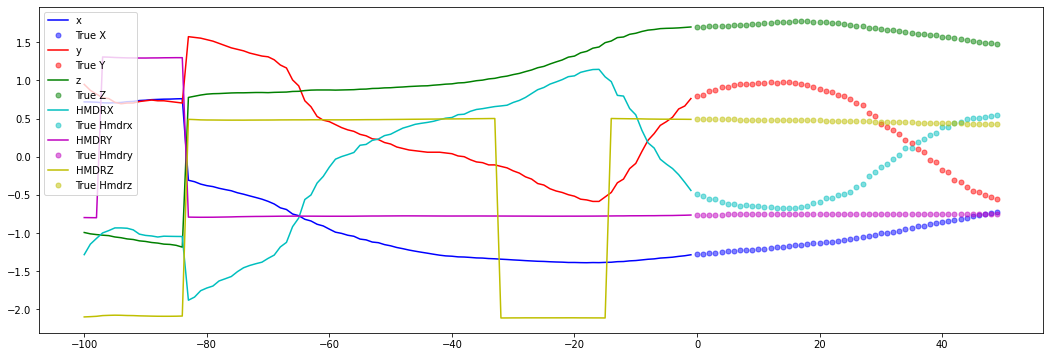

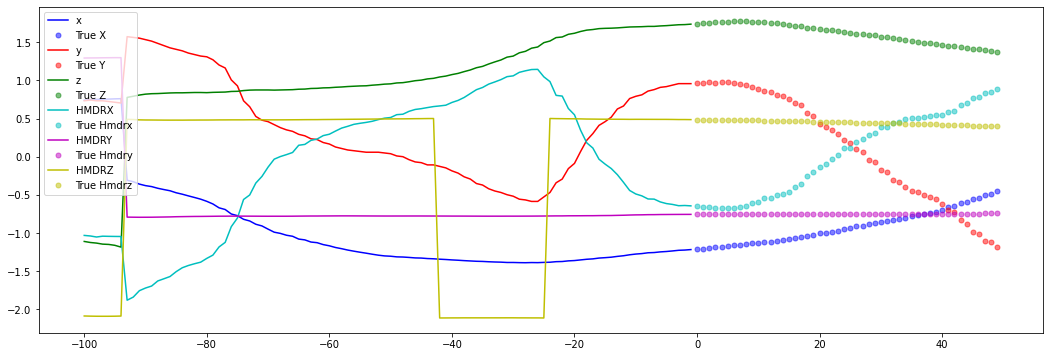

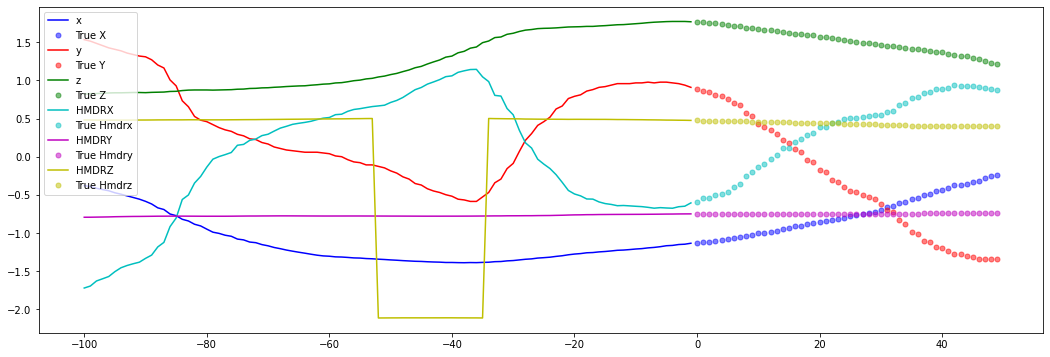

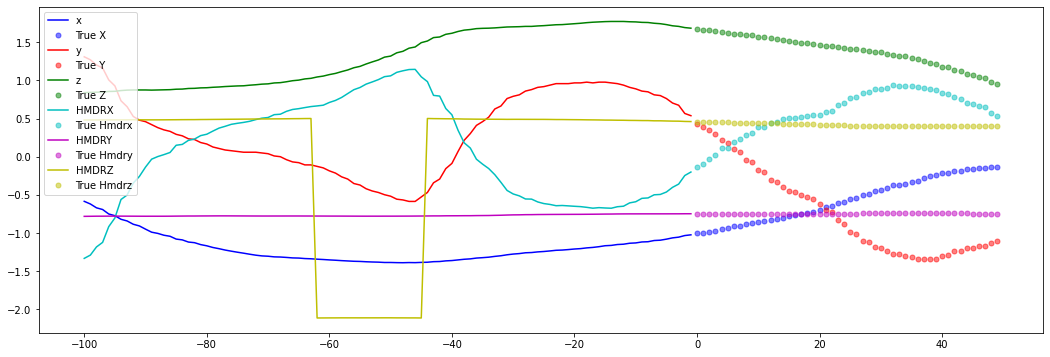

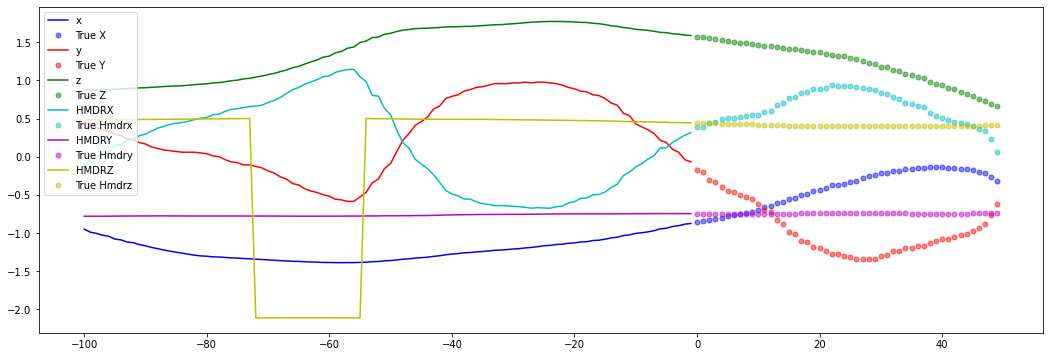

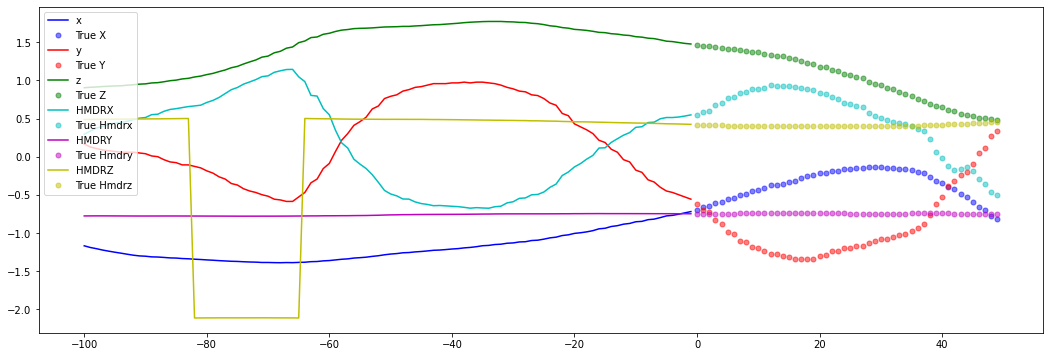

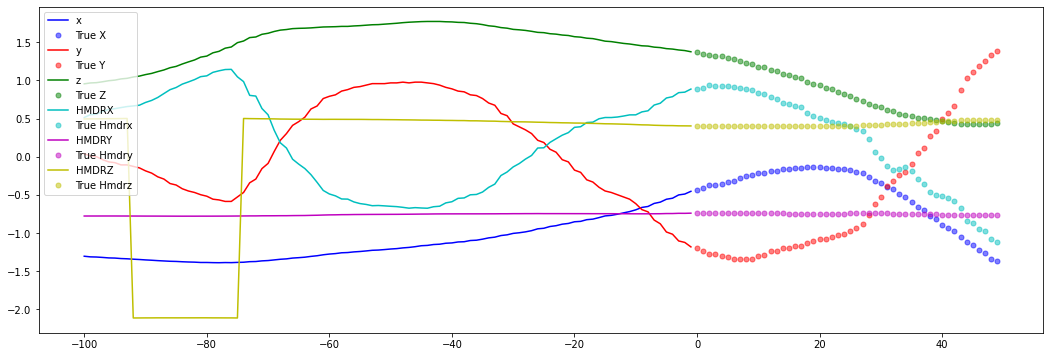

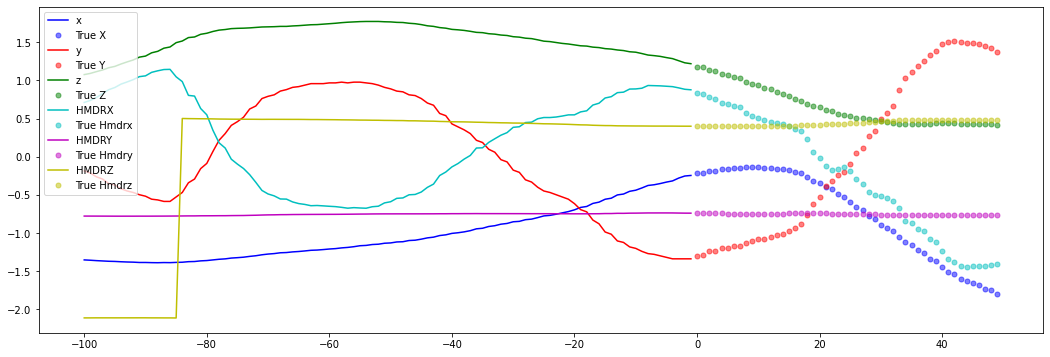

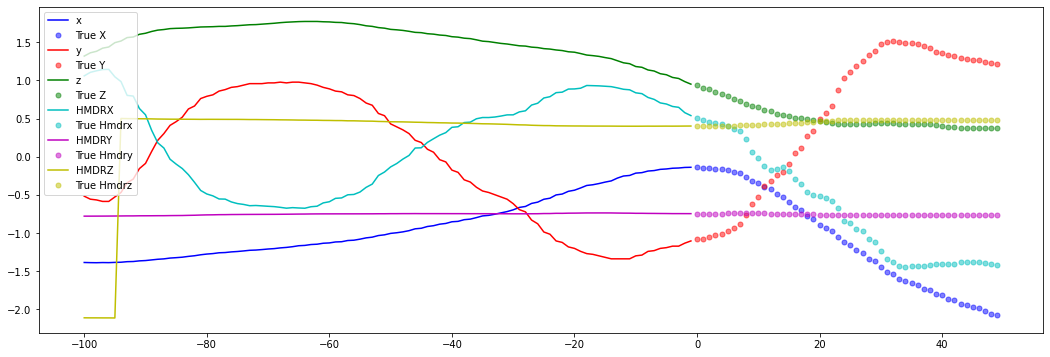

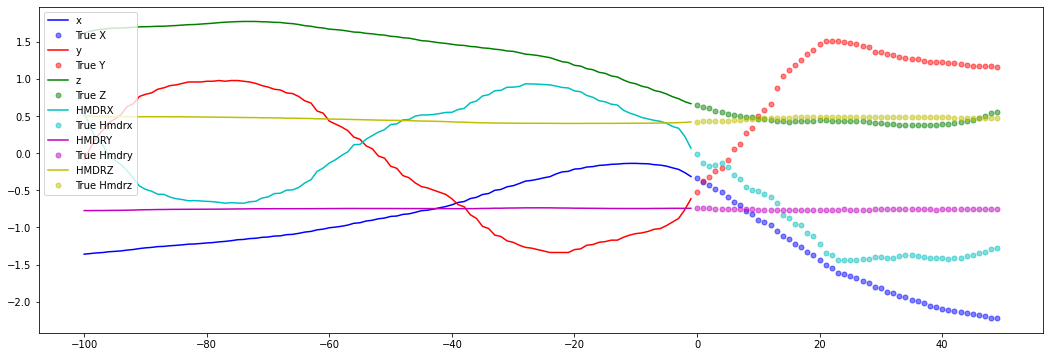

In [ ]:
for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

In [ ]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(GRU(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))


    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))

    model.add(GRU(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [ ]:
EPOCHS = 10
steps_per_epoch = 20
validation_steps = 30
past_history = 70
future_target = 40
STEP = 2
TRAIN_SPLIT = 380
BATCH_SIZE = 28

x_train_multi, y_train_multi = multivariate_multioutput_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset, dataset,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)



train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
#train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()



modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

TypeError: ignored

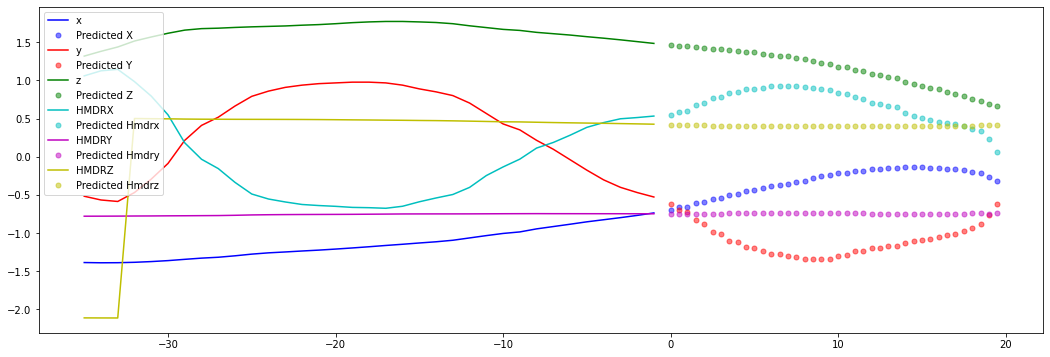

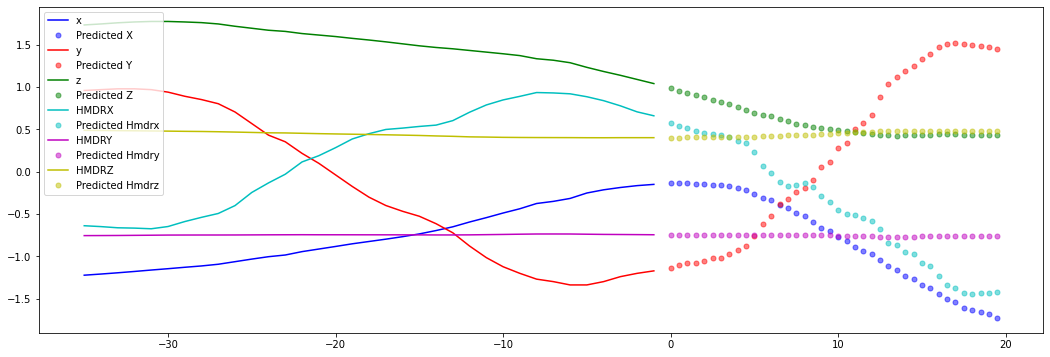

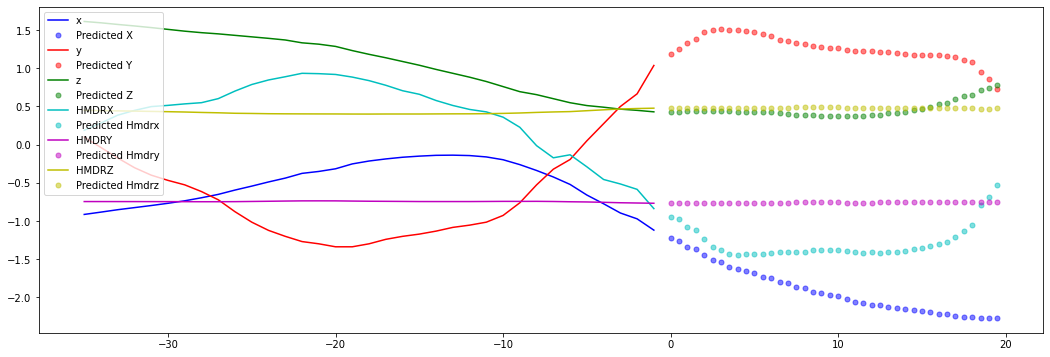

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))